# `Dataset` and `DataLoader` from `torch.utils.data`
On PyTorch's website, there are tutos on how to construct one's own customized dataset, e.g. [here](http://localhost:8888/tree/git-repos/phunc20/ML-frameworks/pytorch/tutorials/Dataset_DataLoader)

However, it won't harm to add a few more remarks. The example given in the link above is as follows.

```python
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
```

What I want to call to attention is that
> this only gives **_an example_**, in the sense that we could follow the skeleton of this example but we are not obliged to structure our data with exactly the same directory structure on our hard disk.

For instance, we do not need to always have a CSV file like in the code.

In order to illustrate this, we will construct a simple dataset of ours together and we will learn the nitty-gritty along the way. To that end, I have hand-made a dataset in the folder `./pets/`, whose structure is like
```
$ tree pets/
pets/
└── train
    ├── bong
    │   ├── IMG-5547.jpg
    │   ├── IMG-5548.jpg
    │   ├── IMG-5549.jpg
    │   └── IMG-5550.jpg
    ├── meochi
    │   ├── IMG-5533.jpg
    │   ├── IMG-5534.jpg
    │   ├── IMG-5536.jpg
    │   └── IMG-5551.jpg
    └── meoem
        ├── IMG-5523.jpg
        ├── IMG-5541.jpg
        ├── IMG-5542.jpg
        └── IMG-5544.jpg

4 directories, 12 files
```
These are the photos of the pets I raise taken by the camera of a smart phone. I have either resized or rotated (or both) these images on purpose in order to

- make them more real
- anticipate some difficulties (as we will see shortly)

**Rmk.** Of course, real-life image dataset won't contain so few images. I just hope that this toy example will help others and myself understand/review PyTorch's `Dataset` and `DataLoader`.

## Let's Get Started
It seems that I forgot to mention the purpose of our dataset: It is created to train a model to distinguish btw each of our pets, named `bong`, `meochi`, `meoem`.<br>
(But we won't train any model in this notebook; here we are just interested in how to set up a dataset for training in PyTorch.)

In [1]:
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

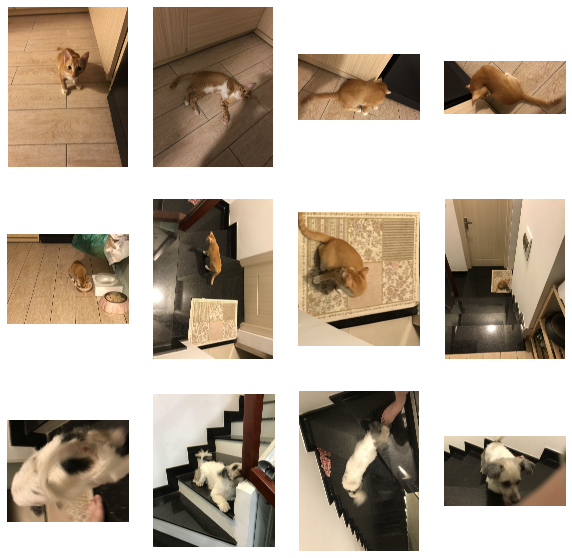

In [2]:
path_train = Path("pets/train")
fig, axs = plt.subplots(3, 4)
fig.set_size_inches((10,10))
for i, pet in enumerate(path_train.iterdir()):
    for j, file in enumerate(pet.iterdir()):
        array = cv2.cvtColor(cv2.imread(str(file)), cv2.COLOR_BGR2RGB)
        axs[i, j].imshow(array)
        axs[i, j].axis("off")

In [3]:
from pathlib import Path
import torch
from torch.utils.data import (
    Dataset,
    DataLoader,
    random_split,
)
from torchvision.transforms import ToTensor
from torchvision.io import read_image

In [4]:
class Pets(Dataset):
    def __init__(self, image_dir, transform=None, target_transform=None):
        self.image_labels = []
        self.image_paths = []
        for path in image_dir.glob("**/*"):
            if path.suffix.lower() not in {".jpg", ".png"}:
                continue
            self.image_paths.append(path)
            label = path.parent.name
            self.image_labels.append(label)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = read_image(image_path)
        label = self.image_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [5]:
!ls

01-flexibility.ipynb  pets  trash.py


In [6]:
train_data = Pets(Path("pets"), transform=ToTensor())
try:
    train_data, val_data = random_split(train_data, [0.85, 0.15])
except Exception as e:
    print(f"dir(e) = {dir(e)}")
    #print(e.with_traceback())
    #print(e.args)
    print(f"{e.__class__.__name__}: {e}")

dir(e) = ['__cause__', '__class__', '__context__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__suppress_context__', '__traceback__', 'args', 'with_traceback']
ValueError: Sum of input lengths does not equal the length of the input dataset!


In [7]:
help(random_split)

Help on function random_split in module torch.utils.data.dataset:

random_split(dataset: torch.utils.data.dataset.Dataset[~T], lengths: Sequence[int], generator: Union[torch._C.Generator, NoneType] = <torch._C.Generator object at 0x7f34bc5ad840>) -> List[torch.utils.data.dataset.Subset[~T]]
    Randomly split a dataset into non-overlapping new datasets of given lengths.
    Optionally fix the generator for reproducible results, e.g.:
    
    >>> random_split(range(10), [3, 7], generator=torch.Generator().manual_seed(42))
    
    Args:
        dataset (Dataset): Dataset to be split
        lengths (sequence): lengths of splits to be produced
        generator (Generator): Generator used for the random permutation.



The above error message seems to indicate that the function `random_split()`'s second arg is expected to be a list of integers, and can not be a list of ratios.

In [8]:
train_data = Pets(Path("pets"), transform=ToTensor())
n_train = int(len(train_data)*0.85)
n_val = len(train_data) - n_train
print(f"len(whole) = {len(train_data)}")
print(f"n_train = {n_train}")
print(f"n_val = {n_val}")
train_data, val_data = random_split(train_data, [n_train, n_val])
train_loader = DataLoader(train_data, batch_size=2)
val_loader = DataLoader(val_data, batch_size=2)

len(whole) = 12
n_train = 10
n_val = 2


In [9]:
try:
    image, label = next(train_data)
    print(image.shape)
except Exception as e:
    print(f"{e.__class__.__name__}: {e}")

TypeError: 'Subset' object is not an iterator


I guess that we should add `iter()`:

In [10]:
try:
    image, label = next(iter(train_data))
    print(image.shape)
except Exception as e:
    print(f"{e.__class__.__name__}: {e}")

RuntimeError: image::read_file() Expected a value of type 'str' for argument '_0' but instead found type 'PosixPath'.
Position: 0
Value: PosixPath('pets/train/meochi/IMG-5551.jpg')
Declaration: image::read_file(str _0) -> (Tensor _0)
Cast error details: Unable to cast Python instance to C++ type (compile in debug mode for details)


I think the above error message means that, like `cv2.imread()`, the function `read_image()` expects its arg as `str`, not as `PosixPath`. Let's try correct it.

In [11]:
class Pets(Dataset):
    def __init__(self, image_dir, transform=None, target_transform=None):
        self.image_labels = []
        self.image_paths = []
        for path in image_dir.glob("**/*"):
            if path.suffix.lower() not in {".jpg", ".png"}:
                continue
            self.image_paths.append(path)
            label = path.parent.name
            self.image_labels.append(label)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = read_image(str(image_path))
        label = self.image_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

train_data = Pets(Path("pets"), transform=ToTensor())
n_train = int(len(train_data)*0.85)
n_val = len(train_data) - n_train
print(f"len(whole) = {len(train_data)}")
print(f"n_train = {n_train}")
print(f"n_val = {n_val}")
train_data, val_data = random_split(train_data, [n_train, n_val])
train_loader = DataLoader(train_data, batch_size=2)
val_loader = DataLoader(val_data, batch_size=2)

try:
    image, label = next(iter(train_data))
    print(image.shape)
except Exception as e:
    print(f"{e.__class__.__name__}: {e}")

len(whole) = 12
n_train = 10
n_val = 2
TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>


In [12]:
class Pets(Dataset):
    def __init__(self, image_dir, transform=None, target_transform=None):
        self.image_labels = []
        self.image_paths = []
        for path in image_dir.glob("**/*"):
            if path.suffix.lower() not in {".jpg", ".png"}:
                continue
            self.image_paths.append(path)
            label = path.parent.name
            self.image_labels.append(label)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = read_image(str(image_path))
        label = self.image_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

train_data = Pets(Path("pets"), transform=ToTensor())
n_train = int(len(train_data)*0.85)
n_val = len(train_data) - n_train
print(f"len(whole) = {len(train_data)}")
print(f"n_train = {n_train}")
print(f"n_val = {n_val}")
train_data, val_data = random_split(train_data, [n_train, n_val])
train_loader = DataLoader(train_data, batch_size=2)
val_loader = DataLoader(val_data, batch_size=2)

try:
    image, label = next(iter(train_data))
    print(image.shape)
except Exception as e:
    print(f"{e.__class__.__name__}: {e}")

len(whole) = 12
n_train = 10
n_val = 2
TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>


The cause of the error is that `ToTensor()` expects its arg to be either `PIL.Image` or `ndarray`, which it will convert to `torch.Tensor`. Meanwhile, `read_image()` already returns a `torch.Tensor`. That is where the conflict takes place.

In conlusion:
- either we set `transform=None` (which happens to be the default)
- or we replace `read_image()` by `cv2.imread()` or `PIL.Image.open()`

### `transform=None`

In [13]:
train_data = Pets(Path("pets"))
n_train = int(len(train_data)*0.85)
n_val = len(train_data) - n_train
print(f"len(whole) = {len(train_data)}")
print(f"n_train = {n_train}")
print(f"n_val = {n_val}")
train_data, val_data = random_split(train_data, [n_train, n_val])
train_loader = DataLoader(train_data, batch_size=2)
val_loader = DataLoader(val_data, batch_size=2)

try:
    image, label = next(iter(train_data))
    print(f"image.shape = {image.shape}")
    print(f"label = {label}")
except Exception as e:
    print(f"{e.__class__.__name__}: {e}")

len(whole) = 12
n_train = 10
n_val = 2
image.shape = torch.Size([3, 1304, 1181])
label = meoem


### `PIL.Image.open()`

In [14]:
from PIL import Image
from PIL.ExifTags import TAGS
from PIL.ImageOps import exif_transpose

INV_TAGS = {info: id_ for id_, info in TAGS.items()}
def pil_loader(path):
    with open(path, "rb") as f:
        image = Image.open(f)
        exif_data = None
        try:
            exif_data = image._getexif()
        except:
            pass
        if exif_data:
            o = exif_data.get(INV_TAGS["Orientation"])
            if o:
                image = exif_transpose(image)
        image = image.convert("RGB")
        return image

class Pets(Dataset):
    def __init__(self, image_dir, transform=None, target_transform=None):
        self.image_labels = []
        self.image_paths = []
        for path in image_dir.glob("**/*"):
            if path.suffix.lower() not in {".jpg", ".png"}:
                continue
            self.image_paths.append(path)
            label = path.parent.name
            self.image_labels.append(label)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = pil_loader(image_path)
        label = self.image_labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

train_data = Pets(Path("pets"), transform=ToTensor())
n_train = int(len(train_data)*0.85)
n_val = len(train_data) - n_train
print(f"len(whole) = {len(train_data)}")
print(f"n_train = {n_train}")
print(f"n_val = {n_val}")
train_data, val_data = random_split(train_data, [n_train, n_val])
train_loader = DataLoader(train_data, batch_size=2)
val_loader = DataLoader(val_data, batch_size=2)

try:
    image, label = next(iter(train_data))
    print(f"image.shape = {image.shape}")
    print(f"label = {label}")
except Exception as e:
    print(f"{e.__class__.__name__}: {e}")

len(whole) = 12
n_train = 10
n_val = 2
image.shape = torch.Size([3, 3816, 3023])
label = bong


## This Is `Dataset`. What About `DataLoader`?

In [15]:
try:
    image, label = next(train_loader)
    print(f"image.shape = {image.shape}")
    print(f"label = {label}")
except Exception as e:
    print(f"{e.__class__.__name__}: {e}")

TypeError: 'DataLoader' object is not an iterator


Like `Dataset`, when being the arg of `next()`, one need to use `iter()` before feeding the `DataLoader` object.

In [16]:
try:
    image, label = next(iter(train_loader))
    print(f"image.shape = {image.shape}")
    print(f"label = {label}")
except Exception as e:
    print(f"{e.__class__.__name__}: {e}")

RuntimeError: stack expects each tensor to be equal size, but got [3, 3816, 3023] at entry 0 and [3, 4032, 3024] at entry 1


The error message seems to suggests that

- `DataLoader` not only helps iterate thru the dataset, but also examines whether the tensors are of the same shape/size, which is quite reasonable since it has this arg called `batch_size` and it needs to ensure tensors in the same batch have the same shape
- on contrast, the tensors need not be of the same shape to be iterated thru within a `Dataset` object

To resize the image to a uniform size, we have at least two options

- `cv2`
- `PIL`
- `torchvision.transforms`

### The `cv2`-Way of Resizing

In [17]:
import cv2
import numpy as np

In [18]:
from torchvision.transforms import Compose

In [19]:
uniform_size = (224, 224)
train_data = Pets(
    Path("pets"),
    transform=Compose([
        lambda image: cv2.resize(np.asarray(image), uniform_size)
        #ToTensor(),
    ]),
)
n_train = int(len(train_data)*0.85)
n_val = len(train_data) - n_train
print(f"len(whole) = {len(train_data)}")
print(f"n_train = {n_train}")
print(f"n_val = {n_val}")
train_data, val_data = random_split(train_data, [n_train, n_val])
train_loader = DataLoader(train_data, batch_size=2)
val_loader = DataLoader(val_data, batch_size=2)

try:
    image, label = next(iter(train_loader))
    print(f"image.shape = {image.shape}")
    print(f"label = {label}")
except Exception as e:
    print(f"{e.__class__.__name__}: {e}")

len(whole) = 12
n_train = 10
n_val = 2
image.shape = torch.Size([2, 224, 224, 3])
label = ('bong', 'meochi')


**N.B.** Note that the `torch.Size` has the color channel as the last channel because we stay in the `numpy/cv2` land; we could have the color channel shifted by adding `ToTensor()` or manually shifting it by `np.transpose()`, etc.

### The `PIL`-Way of Resizing

In [20]:
uniform_size = (224, 224)
train_data = Pets(
    Path("pets"),
    transform=Compose([
        lambda image: image.resize(uniform_size),
        ToTensor(),
    ]),
)
n_train = int(len(train_data)*0.85)
n_val = len(train_data) - n_train
print(f"len(whole) = {len(train_data)}")
print(f"n_train = {n_train}")
print(f"n_val = {n_val}")
train_data, val_data = random_split(train_data, [n_train, n_val])
train_loader = DataLoader(train_data, batch_size=2)
val_loader = DataLoader(val_data, batch_size=2)

try:
    image, label = next(iter(train_loader))
    print(f"image.shape = {image.shape}")
    print(f"label = {label}")
except Exception as e:
    print(f"{e.__class__.__name__}: {e}")

len(whole) = 12
n_train = 10
n_val = 2
image.shape = torch.Size([2, 3, 224, 224])
label = ('bong', 'bong')


### The `torchvision.transforms`-Way of Resizing

In [21]:
from torchvision.transforms import (
    Normalize,
    Resize,
    RandomHorizontalFlip,
    RandomResizedCrop,
)

In [22]:
uniform_size = (224, 224)
normalize = Normalize(mean=[0.5]*3, std=[0.5]*3)
train_data = Pets(
    Path("pets"),
    transform=Compose([
        RandomResizedCrop(uniform_size),
        RandomHorizontalFlip(),
        ToTensor(),
        normalize,
    ]),
)
n_train = int(len(train_data)*0.85)
n_val = len(train_data) - n_train
print(f"len(whole) = {len(train_data)}")
print(f"n_train = {n_train}")
print(f"n_val = {n_val}")
train_data, val_data = random_split(train_data, [n_train, n_val])
train_loader = DataLoader(train_data, batch_size=2)
val_loader = DataLoader(val_data, batch_size=2)

try:
    image, label = next(iter(train_loader))
    print(f"image.shape = {image.shape}")
    print(f"label = {label}")
except Exception as e:
    print(f"{e.__class__.__name__}: {e}")

len(whole) = 12
n_train = 10
n_val = 2
image.shape = torch.Size([2, 3, 224, 224])
label = ('meoem', 'meoem')


## More Q&A's

- Does `Dataset` randomly shuffles?
- How to do data augmentation using `Dataset`/`DataLoader`?
  - "**The `torchvision.transforms`-way of resizing**" above provides an answer.
- prefetch like `tf.dataset`

### Shuffling

In [23]:
for image, label in train_loader:
    print(f"image.shape = {image.shape}")
    print(f"label = {label}")

image.shape = torch.Size([2, 3, 224, 224])
label = ('meoem', 'meoem')
image.shape = torch.Size([2, 3, 224, 224])
label = ('meochi', 'bong')
image.shape = torch.Size([2, 3, 224, 224])
label = ('meoem', 'meochi')
image.shape = torch.Size([2, 3, 224, 224])
label = ('bong', 'meoem')
image.shape = torch.Size([2, 3, 224, 224])
label = ('meochi', 'bong')


In [24]:
for image, label in train_loader:
    print(f"image.shape = {image.shape}")
    print(f"label = {label}")

image.shape = torch.Size([2, 3, 224, 224])
label = ('meoem', 'meoem')
image.shape = torch.Size([2, 3, 224, 224])
label = ('meochi', 'bong')
image.shape = torch.Size([2, 3, 224, 224])
label = ('meoem', 'meochi')
image.shape = torch.Size([2, 3, 224, 224])
label = ('bong', 'meoem')
image.shape = torch.Size([2, 3, 224, 224])
label = ('meochi', 'bong')


It seems that within an epoque instances are shuffled, but across
epoques the order of appearance is the same. But this behaviour can be changed, e.g. via the `shuffle` arg of the `DataLoader` object.

In [25]:
train_data = Pets(
    Path("pets"),
    transform=Compose([
        RandomResizedCrop(uniform_size),
        RandomHorizontalFlip(),
        ToTensor(),
        normalize,
    ]),
)
train_loader = DataLoader(train_data, batch_size=2, shuffle=True)

In [26]:
for image, label in train_loader:
    print(f"image.shape = {image.shape}")
    print(f"label = {label}")

image.shape = torch.Size([2, 3, 224, 224])
label = ('bong', 'bong')
image.shape = torch.Size([2, 3, 224, 224])
label = ('meochi', 'meoem')
image.shape = torch.Size([2, 3, 224, 224])
label = ('meochi', 'bong')
image.shape = torch.Size([2, 3, 224, 224])
label = ('meoem', 'meochi')
image.shape = torch.Size([2, 3, 224, 224])
label = ('meoem', 'meochi')
image.shape = torch.Size([2, 3, 224, 224])
label = ('meoem', 'bong')


In [27]:
for image, label in train_loader:
    print(f"image.shape = {image.shape}")
    print(f"label = {label}")

image.shape = torch.Size([2, 3, 224, 224])
label = ('meochi', 'meochi')
image.shape = torch.Size([2, 3, 224, 224])
label = ('bong', 'meochi')
image.shape = torch.Size([2, 3, 224, 224])
label = ('bong', 'meoem')
image.shape = torch.Size([2, 3, 224, 224])
label = ('bong', 'meoem')
image.shape = torch.Size([2, 3, 224, 224])
label = ('meoem', 'meoem')
image.shape = torch.Size([2, 3, 224, 224])
label = ('meochi', 'bong')


### Prefecthing